# Task 1: Fine-tune Chemical Language Model

The goal is to fine-tune a pre-trained chemical language model on a regression task using the Lipophilicity dataset. The task involves predicting the lipophilicity value for a given molecule representation (SMILES string). You will learn how to load and tokenize a dataset from HuggingFace, how to load a pre-trained language model, and finally, how to run a model in inference mode.

Your task is to complete the missing code blocks below.

In [1]:
# import dependencies
import torch
from datasets import load_dataset
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm.notebook import tqdm
import random
import numpy as np

# 1.Fine-tune a Chemical Language Model on Lipophilicity


## --- Step 1: Load Dataset ---

The dataset we are going to use is the [Lipophilicity](https://huggingface.co/datasets/scikit-fingerprints/MoleculeNet_Lipophilicity) dataset, part of [MoleculeNet](https://pubs.rsc.org/en/content/articlelanding/2018/sc/c7sc02664a) benchmark.

Lipophilicity, also known as hydrophobicity, is a measure of how readily a substance dissolves in nonpolar solvents (such as oil) compared to polar solvents (such as water).

In [2]:
# specify dataset name and model name
DATASET_PATH = "scikit-fingerprints/MoleculeNet_Lipophilicity"
MODEL_NAME = "ibm/MoLFormer-XL-both-10pct"  #MoLFormer model

In [3]:
# load the dataset from HuggingFace
dataset = load_dataset(DATASET_PATH)

README.md:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

lipophilicity.csv:   0%|          | 0.00/223k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4200 [00:00<?, ? examples/s]

In [4]:
# Explore the dataset
# Load the dataset
dataset = load_dataset("scikit-fingerprints/MoleculeNet_Lipophilicity")

# Print column names
print("Column names:", dataset["train"].column_names)

# Display the first 5 rows
print("\nSample rows:")
for i, row in enumerate(dataset["train"]):
    if i >= 5:  # Display only the first 5 rows
        break
    print(f"Row {i + 1}: {row}")

# Analyze the dataset
print("\nDataset analysis:")
print("Number of samples in the training set:", len(dataset["train"]))

# Check the distribution of the target variable
target_values = dataset["train"]["label"]
print("Mean of target values:", np.mean(target_values))
print("Standard deviation of target values:", np.std(target_values))


Column names: ['SMILES', 'label']

Sample rows:
Row 1: {'SMILES': 'Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14', 'label': 3.54}
Row 2: {'SMILES': 'COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)CCc3ccccc23', 'label': -1.18}
Row 3: {'SMILES': 'COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl', 'label': 3.69}
Row 4: {'SMILES': 'OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(Cl)sc4[nH]3', 'label': 3.37}
Row 5: {'SMILES': 'Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)NCC#N)c1', 'label': 3.1}

Dataset analysis:
Number of samples in the training set: 4200
Mean of target values: 2.186335714285714
Standard deviation of target values: 1.2028604901336188


In [5]:
# define a PyTorch Dataset class for handling SMILES strings and targets

class SMILESDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        """
        Initialize the SMILES dataset.
        
        Args:
            data: HuggingFace dataset containing SMILES strings and targets
            tokenizer: Tokenizer for the MoLFormer model
            max_length: Maximum length for tokenization padding/truncation
        """
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        Get a single sample from the dataset.
        
        Args:
            idx: Index of the sample to retrieve
            
        Returns:
            Dictionary containing input_ids, attention_mask, and labels
        """
        # Handle Subset indexing
        if isinstance(self.data, Subset):
            item = self.data.dataset[self.data.indices[idx]]
        else:
            item = self.data[idx]
        
        # Get the SMILE and target
        # Using 'canonical_smiles' 
        smiles = item['SMILES']
        target = item['label']  
        
        # Tokenize the SMILES string
        encoding = self.tokenizer(
            smiles,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Remove the batch dimension added by the tokenizer
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        
        # Convert target to tensor
        target = torch.tensor(target, dtype=torch.float32)
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': target
        }

## --- Step 2: Split Dataset ---

As there is only one split (train split) in the original dataset, we need to split the data into training and testing sets by ourselves.

In [6]:
# tokenize the data
# load a pre-trained tokenizer from HuggingFace
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenization_molformer_fast.py:   0%|          | 0.00/6.50k [00:00<?, ?B/s]

tokenization_molformer.py:   0%|          | 0.00/9.48k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer_fast.py
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/41.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/54.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [7]:
# split the data into training and test datasets
def split_dataset(dataset, tokenizer, test_size=0.2, random_state=42):
    """
    Split a dataset into training and test sets.
    
    Args:
        dataset: HuggingFace dataset to split
        tokenizer: Tokenizer for processing SMILES strings
        test_size: Proportion of dataset to use for testing (default: 0.2)
        random_state: Random seed for reproducibility (default: 42)
    
    Returns:
        train_data: SMILESDataset for training
        test_data: SMILESDataset for testing
    """
    # Set random seeds for reproducibility
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    random.seed(random_state)
    
    # Get total number of samples
    total_samples = len(dataset['train'])
    
    # Generate random indices for splitting
    indices = list(range(total_samples))
    random.shuffle(indices)
    
    # Calculate split point
    split_idx = int(total_samples * (1 - test_size))
    
    # Split indices into train and test
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]
    
    # Create Subset datasets
    train_dataset = Subset(dataset['train'], train_indices)
    test_dataset = Subset(dataset['train'], test_indices)
    
    # Create SMILES datasets with the tokenizer
    train_data = SMILESDataset(train_dataset, tokenizer)
    test_data = SMILESDataset(test_dataset, tokenizer)
    
    # Print dataset sizes
    print(f"Total dataset size: {total_samples}")
    print(f"Training set size: {len(train_data)}")
    print(f"Test set size: {len(test_data)}")
    
    return train_data, test_data

train_data, test_data = split_dataset(dataset, tokenizer)


Total dataset size: 4200
Training set size: 3360
Test set size: 840


In [8]:
# construct Pytorch data loaders for both train and test datasets
BATCH_SIZE = 16 # adjust based on memory constraints

# Create DataLoader for training data
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle training data for better training
    num_workers=2,  # Number of subprocesses for data loading
    pin_memory=True  # Pin memory for faster data transfer to GPU
)

# Create DataLoader for test data
test_loader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle test data
    num_workers=2,
    pin_memory=True
)

## --- Step 3: Load Model ---

In [9]:
# load pre-trained model from HuggingFace
model = AutoModel.from_pretrained(MODEL_NAME, deterministic_eval=True, trust_remote_code=True)

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

configuration_molformer.py:   0%|          | 0.00/7.60k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- configuration_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_molformer.py:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- modeling_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/187M [00:00<?, ?B/s]

In [10]:
# We need to add a regression head on the language model as we are doing a regression task.

# specify model with a regression head

class MoLFormerWithRegressionHead(nn.Module):
    def __init__(self, base_model, dropout_rate=0.1):
        """
        Initialize the MoLFormer model with a regression head.
        
        Args:
            base_model: Pre-trained MoLFormer model
            dropout_rate: Dropout probability for regularization
        """
        super().__init__()
        
        # Base MoLFormer model
        self.base_model = base_model
        
        # Get the hidden size from the base model config
        hidden_size = base_model.config.hidden_size
        
        # Regression head
        self.regression_head = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size // 2, 1)
        )
        
    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the model.
        
        Args:
            input_ids: Tokenized input sequences
            attention_mask: Attention mask for the sequences
            
        Returns:
            Predicted values (logits)
        """
        # Get the output from base model
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Get the [CLS] token representation (first token)
        sequence_output = outputs.last_hidden_state[:, 0, :]
        
        # Pass through regression head
        logits = self.regression_head(sequence_output)
        
        return logits.squeeze(-1)  # Remove last dimension for single value prediction

In [11]:
# initialize the regression model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model = MoLFormerWithRegressionHead(model).to(device)

## --- Step 4: Training ---

In [12]:
# Import necessary libraries
import torch
import torch.optim as optim
from keras.callbacks import ReduceLROnPlateau
from tqdm.notebook import tqdm
import os

# Define device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(
    regression_model.parameters(),
    lr=2e-5,
    weight_decay=0.01
)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=2,
    verbose=True
)

def train_model_with_early_stopping(
    model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10, patience=3
):
    """
    Train the model with early stopping.
    
    Args:
        model: Model to train
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        criterion: Loss function
        optimizer: Optimizer for training
        scheduler: Learning rate scheduler
        epochs: Maximum number of epochs to train
        patience: Number of epochs to wait for improvement before early stopping
        
    Returns:
        model: The trained model
        best_val_loss: The lowest validation loss achieved
    """
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
        
        for batch in progress_bar:
            # Get batch data using dictionary keys
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Update progress bar and epoch loss
            epoch_loss += loss.item()
            progress_bar.set_postfix({"Loss": loss.item()})
        
        # Print epoch loss
        avg_train_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}")
        
        # Validate the model
        val_loss = validate_model(model, val_loader, criterion)
        print(f"Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}")
        
        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)
        
        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            
            # Save the model to both working directory and Kaggle output
            torch.save(model.state_dict(), "best_model.pth")
            
            # Also save to Kaggle output directory to ensure persistence
            if os.path.exists("/kaggle/working"):
                output_path = "/kaggle/working/best_model.pth"
                torch.save(model.state_dict(), output_path)
            
            print(f"New best model saved with validation loss: {val_loss:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break
    
    # Return the model and best validation loss
    return model, best_val_loss

def validate_model(model, val_loader, criterion):
    """
    Validate the model on the validation set.
    
    Args:
        model: Model to validate
        val_loader: DataLoader for validation data
        criterion: Loss function
        
    Returns:
        val_loss: Average validation loss
    """
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for batch in val_loader:
            # Get batch data using dictionary keys
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            
            # Accumulate validation loss
            val_loss += loss.item()
    
    return val_loss / len(val_loader)

# Train the model
print("Starting model training...")
trained_model, best_loss = train_model_with_early_stopping(
    model=regression_model,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=10,
    patience=3
)

# Verify that the model file was created
if os.path.exists("best_model.pth"):
    print("best_model.pth was successfully created!")
    print(f"File size: {os.path.getsize('best_model.pth') / (1024*1024):.2f} MB")
else:
    print("best_model.pth was not created. Check for errors in the training process.")

print("Model training complete!")

Using device: cuda
Starting model training...


Epoch 1/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 1, Training Loss: 1.2712
Epoch 1, Validation Loss: 0.8465
New best model saved with validation loss: 0.8465


Epoch 2/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 2, Training Loss: 0.6635
Epoch 2, Validation Loss: 0.7117
New best model saved with validation loss: 0.7117


Epoch 3/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 3, Training Loss: 0.4683
Epoch 3, Validation Loss: 0.5940
New best model saved with validation loss: 0.5940


Epoch 4/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 4, Training Loss: 0.3837
Epoch 4, Validation Loss: 0.5760
New best model saved with validation loss: 0.5760


Epoch 5/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 5, Training Loss: 0.3337
Epoch 5, Validation Loss: 0.5310
New best model saved with validation loss: 0.5310


Epoch 6/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 6, Training Loss: 0.2865
Epoch 6, Validation Loss: 0.5247
New best model saved with validation loss: 0.5247


Epoch 7/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 7, Training Loss: 0.2466
Epoch 7, Validation Loss: 0.4451
New best model saved with validation loss: 0.4451


Epoch 8/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 8, Training Loss: 0.2176
Epoch 8, Validation Loss: 0.4552


Epoch 9/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 9, Training Loss: 0.1861
Epoch 9, Validation Loss: 0.4466


Epoch 10/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 10, Training Loss: 0.1792
Epoch 10, Validation Loss: 0.5201
Early stopping triggered at epoch 10
best_model.pth was successfully created!
File size: 170.68 MB
Model training complete!


## --- Step 5: Evaluation ---

Loaded best model from best_model.pth


<ipython-input-13-02e63a0c517b>:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  regression_model.load_state_dict(torch.load(best_model_path))


Evaluating:   0%|          | 0/53 [00:00<?, ?it/s]


Test Results:
Average Loss: 0.4451
MSE: 0.4459
RMSE: 0.6677
MAE: 0.5135
R²: 0.7201


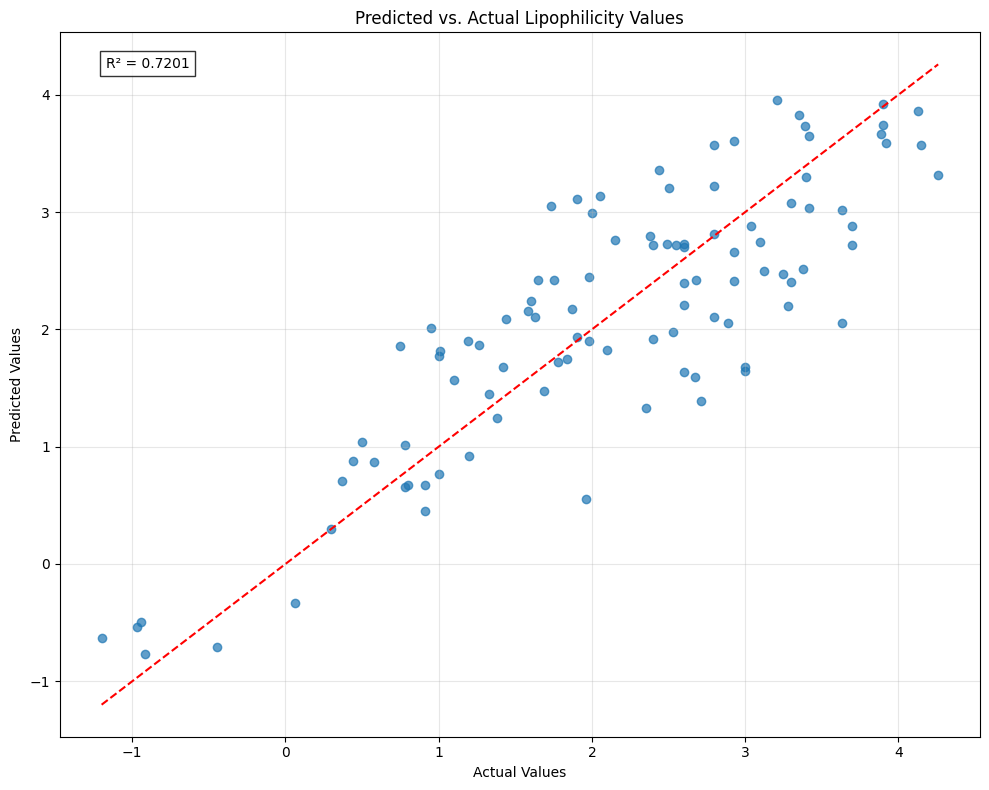

In [13]:
def evaluate_model(model, test_loader, criterion, device):
    """
    Evaluate the model on the test set and compute various metrics.
    
    Args:
        model: Trained model to evaluate
        test_loader: DataLoader for test dataset
        criterion: Loss function
        device: Device to run evaluation on
        
    Returns:
        dict: Dictionary of evaluation metrics
    """
    model.eval()  # Set model to evaluation mode
    
    # Initialize metrics
    test_loss = 0.0
    all_preds = []
    all_labels = []
    
    # Evaluate without computing gradients
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            # Move batch data to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # Compute loss
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            # Store predictions and true labels for metric calculation
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Mean Squared Error (MSE)
    mse = np.mean((all_preds - all_labels) ** 2)
    
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(all_preds - all_labels))
    
    # R-squared (coefficient of determination)
    y_mean = np.mean(all_labels)
    ss_total = np.sum((all_labels - y_mean) ** 2)
    ss_residual = np.sum((all_labels - all_preds) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    
    # Average test loss
    avg_loss = test_loss / len(test_loader)
    
    # Display results
    print("\nTest Results:")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    # Return metrics as dictionary
    metrics = {
        'loss': avg_loss,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }
    
    return metrics

# Load the best model (if you saved one during training)
try:
    best_model_path = "best_model.pth"
    regression_model.load_state_dict(torch.load(best_model_path))
    print(f"Loaded best model from {best_model_path}")
except FileNotFoundError:
    print("No saved model found, using the current model state")

# Evaluate the model
evaluation_metrics = evaluate_model(
    model=regression_model,
    test_loader=test_loader,
    criterion=nn.MSELoss(),
    device=device
)

# Visualize predictions vs. actual values
def plot_predictions(model, test_loader, device, max_samples=100):
    """
    Create a scatter plot of predicted vs. actual values.
    
    Args:
        model: Trained model
        test_loader: DataLoader for test dataset
        device: Device to run predictions on
        max_samples: Maximum number of samples to plot
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            # Move batch data to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # Store predictions and true labels
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Limit the number of samples
            if len(all_preds) >= max_samples:
                all_preds = all_preds[:max_samples]
                all_labels = all_labels[:max_samples]
                break
    
    # Convert to numpy arrays
    predictions = np.array(all_preds)
    actual = np.array(all_labels)
    
    # Plot
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 8))
    plt.scatter(actual, predictions, alpha=0.7)
    
    # Add perfect prediction line
    min_val = min(np.min(actual), np.min(predictions))
    max_val = max(np.max(actual), np.max(predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predicted vs. Actual Lipophilicity Values')
    plt.grid(True, alpha=0.3)
    
    # Add R² value to plot
    r2 = evaluation_metrics['r2']
    plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=plt.gca().transAxes, 
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('prediction_scatter.png')
    plt.show()

# Plot predictions vs. actual values
plot_predictions(regression_model, test_loader, device)

# 2.Add Unsupervised Finetuning
In this step, you will perform unsupervised fine-tuning on the training dataset. This means the model will leverage only the SMILES strings without any corresponding labels to adapt its understanding of the data distribution. By familiarizing the model with the patterns and structure of the SMILES strings, you can potentially enhance its performance on downstream supervised tasks.

For this fine-tuning, you will use the Masked Language Modeling (MLM) objective, where the model learns to predict randomly masked tokens within the input sequence. Remember to save the fine-tuned model for later use.


In [14]:
# Create a dataset class for unsupervised fine-tuning
class UnsupervisedSMILESDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        """
        Dataset for unsupervised fine-tuning using MLM.
        Only uses SMILES strings without labels.
        
        Args:
            data: HuggingFace dataset containing SMILES strings
            tokenizer: Tokenizer for the MoLFormer model
            max_length: Maximum length for tokenization padding/truncation
        """
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.data)
    
    def __getitem__(self, idx):
        """Get a single sample from the dataset."""
        # Handle Subset indexing
        if isinstance(self.data, Subset):
            item = self.data.dataset[self.data.indices[idx]]
        else:
            item = self.data[idx]
        
        # Get only the SMILES string
        smiles = item['SMILES']
        
        # Tokenize the SMILES string (without masking - DataCollator will handle that)
        encoding = self.tokenizer(
            smiles,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Remove the batch dimension
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0)
        }


# Setup for unsupervised fine-tuning
def setup_unsupervised_finetuning(dataset, tokenizer, batch_size=8):
    """
    Set up the components needed for unsupervised fine-tuning.
    
    Args:
        dataset: Dataset containing SMILES strings
        tokenizer: MoLFormer tokenizer
        batch_size: Batch size for training
        
    Returns:
        model, data_loader, data_collator
    """
    print("Setting up unsupervised fine-tuning...")
    
    # Create unsupervised dataset
    unsup_dataset = UnsupervisedSMILESDataset(
        data=dataset['train'],
        tokenizer=tokenizer
    )
    print(f"Unsupervised dataset size: {len(unsup_dataset)}")
    
    # Create data collator for masked language modeling
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=True,  # Enable masked language modeling
        mlm_probability=0.15  # Standard masking probability
    )
    
    # Create data loader
    data_loader = DataLoader(
        unsup_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=data_collator
    )
    
    # Load pre-trained model for MLM (using AutoModelForMaskedLM)
    model = AutoModelForMaskedLM.from_pretrained(
        MODEL_NAME,
        trust_remote_code=True
    )
    
    return model, data_loader, data_collator


# Training function for unsupervised fine-tuning
def train_unsupervised(model, data_loader, num_epochs=3, learning_rate=5e-5, device='cuda'):
    """
    Perform unsupervised fine-tuning using MLM objective.
    
    Args:
        model: Model to fine-tune
        data_loader: Data loader with masked inputs
        num_epochs: Number of training epochs
        learning_rate: Learning rate
        device: Training device
        
    Returns:
        Fine-tuned model
    """
    print("\nStarting unsupervised fine-tuning...")
    
    # Move model to device
    model = model.to(device)
    model.train()
    
    # Setup optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(num_epochs):
        epoch_loss = 0
        progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch in progress_bar:
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Update progress
            epoch_loss += loss.item()
            progress_bar.set_postfix({"Loss": loss.item()})
        
        avg_epoch_loss = epoch_loss / len(data_loader)
        print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_epoch_loss:.4f}")
    
    # Save the fine-tuned model
    model_save_path = "molformer_mlm_finetuned"
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)
    print(f"Saved fine-tuned model to {model_save_path}")
    
    return model


# Main function to execute unsupervised fine-tuning
def run_unsupervised_finetuning(dataset, tokenizer, batch_size=8, num_epochs=3):
    """
    Run the entire unsupervised fine-tuning pipeline.
    
    Args:
        dataset: Dataset containing SMILES strings
        tokenizer: MoLFormer tokenizer
        batch_size: Batch size for training
        num_epochs: Number of training epochs
        
    Returns:
        Fine-tuned model base path
    """
    print("\n=== Starting Unsupervised Fine-tuning ===\n")
    
    # Setup components
    mlm_model, data_loader, _ = setup_unsupervised_finetuning(
        dataset=dataset,
        tokenizer=tokenizer,
        batch_size=batch_size
    )
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Run training
    fine_tuned_model = train_unsupervised(
        model=mlm_model,
        data_loader=data_loader,
        num_epochs=num_epochs,
        device=device
    )
    
    print("\n=== Unsupervised Fine-tuning Completed ===\n")
    
    return "molformer_mlm_finetuned"


# Execute unsupervised fine-tuning
finetuned_model_path = run_unsupervised_finetuning(
    dataset=dataset,
    tokenizer=tokenizer,
    batch_size=8,  # Adjust based on available memory
    num_epochs=3   # You can increase for better results
)

print(f"Fine-tuned model saved at: {finetuned_model_path}")
print("You can now use this model for supervised fine-tuning by loading it with:")
print(f"model = AutoModel.from_pretrained('{finetuned_model_path}')")


=== Starting Unsupervised Fine-tuning ===

Setting up unsupervised fine-tuning...
Unsupervised dataset size: 4200
Using device: cuda

Starting unsupervised fine-tuning...


Epoch 1/3:   0%|          | 0/525 [00:00<?, ?it/s]

Epoch 1/3 - Average Loss: 0.2720


Epoch 2/3:   0%|          | 0/525 [00:00<?, ?it/s]

Epoch 2/3 - Average Loss: 0.1844


Epoch 3/3:   0%|          | 0/525 [00:00<?, ?it/s]

Epoch 3/3 - Average Loss: 0.1626
Saved fine-tuned model to molformer_mlm_finetuned

=== Unsupervised Fine-tuning Completed ===

Fine-tuned model saved at: molformer_mlm_finetuned
You can now use this model for supervised fine-tuning by loading it with:
model = AutoModel.from_pretrained('molformer_mlm_finetuned')


# 3.Fine-Tune for Comparison
After performing unsupervised fine-tuning on the training data, we now fine-tune the model on the regression task with the regression head. By comparing the performance of the model before and after unsupervised fine-tuning, you can evaluate how the unsupervised fine-tuning impacts the model's performance on our target task.


In [15]:
# Define a function to train and evaluate a model
def train_and_evaluate(model_base, model_name, train_loader, test_loader, device, 
                       learning_rate=2e-5, weight_decay=0.01, epochs=10, patience=3):
    """
    Train and evaluate a model, returning evaluation metrics.
    
    Args:
        model_base: Base model to use for regression
        model_name: Name of the model for logging
        train_loader: DataLoader for training
        test_loader: DataLoader for testing
        device: Device to run on
        learning_rate: Learning rate for optimizer
        weight_decay: Weight decay for regularization
        epochs: Maximum number of epochs
        patience: Early stopping patience
        
    Returns:
        model: Trained model
        metrics: Evaluation metrics dictionary
    """
    print(f"\n{'='*20} Training {model_name} {'='*20}")
    
    # Initialize regression model
    regression_model = MoLFormerWithRegressionHead(model_base).to(device)
    
    # Initialize optimizer and loss function
    optimizer = torch.optim.AdamW(
        regression_model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )
    criterion = nn.MSELoss()
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=2, verbose=True
    )
    
    # Training loop with early stopping
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # Training phase
        regression_model.train()
        train_loss = 0.0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch in progress_bar:
            # Get batch data
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = regression_model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Update metrics
            train_loss += loss.item()
            progress_bar.set_postfix({"Loss": loss.item()})
        
        avg_train_loss = train_loss / len(train_loader)
        
        # Evaluation phase
        regression_model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = regression_model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(test_loader)
        
        # Print epoch results
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Check for improvement
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
            best_model_state = regression_model.state_dict().copy()
            print(f"New best model with validation loss: {best_val_loss:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
    
    # Load best model for evaluation
    if best_model_state is not None:
        regression_model.load_state_dict(best_model_state)
    
    # Save the best model
    torch.save(regression_model.state_dict(), f"best_{model_name}.pt")
    print(f"Saved best model to best_{model_name}.pt")
    
    # Comprehensive evaluation
    regression_model.eval()
    
    # Initialize metrics
    all_preds = []
    all_labels = []
    
    # Gather predictions
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Final evaluation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = regression_model(input_ids, attention_mask)
            
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    mse = np.mean((all_preds - all_labels) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(all_preds - all_labels))
    
    # R-squared
    y_mean = np.mean(all_labels)
    ss_total = np.sum((all_labels - y_mean) ** 2)
    ss_residual = np.sum((all_labels - all_preds) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    
    # Compile metrics
    metrics = {
        'model_name': model_name,
        'loss': best_val_loss,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }
    
    # Print results
    print(f"\n{'-'*20} Evaluation Results for {model_name} {'-'*20}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    return regression_model, metrics


# Function to visualize and compare model performances
def compare_models(model_metrics, test_loader, device):
    """
    Create comparison plots for models.
    
    Args:
        model_metrics: List of tuples containing (model, metrics)
        test_loader: DataLoader for testing
        device: Device to run on
    """
    import matplotlib.pyplot as plt
    
    # 1. Bar chart of evaluation metrics
    metrics_df = pd.DataFrame([m for _, m in model_metrics])
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot MSE
    axes[0, 0].bar(metrics_df['model_name'], metrics_df['mse'], color=['blue', 'green'])
    axes[0, 0].set_title('Mean Squared Error (MSE)')
    axes[0, 0].set_ylabel('MSE')
    
    # Plot RMSE
    axes[0, 1].bar(metrics_df['model_name'], metrics_df['rmse'], color=['blue', 'green'])
    axes[0, 1].set_title('Root Mean Squared Error (RMSE)')
    axes[0, 1].set_ylabel('RMSE')
    
    # Plot MAE
    axes[1, 0].bar(metrics_df['model_name'], metrics_df['mae'], color=['blue', 'green'])
    axes[1, 0].set_title('Mean Absolute Error (MAE)')
    axes[1, 0].set_ylabel('MAE')
    
    # Plot R²
    axes[1, 1].bar(metrics_df['model_name'], metrics_df['r2'], color=['blue', 'green'])
    axes[1, 1].set_title('R² Score')
    axes[1, 1].set_ylabel('R²')
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig('model_comparison_metrics.png')
    plt.close()
    
    # 2. Scatter plots with actual vs. predicted values
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    colors = ['blue', 'green']
    markers = ['o', 'x']
    
    for i, (model, metrics) in enumerate(model_metrics):
        # Get predictions
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids, attention_mask)
                
                all_preds.extend(outputs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Convert to numpy arrays
        preds = np.array(all_preds)
        labels = np.array(all_labels)
        
        # Plot in separate subplots
        axes[i].scatter(labels, preds, alpha=0.6, color=colors[i], marker=markers[i])
        
        # Add perfect prediction line
        min_val = min(np.min(labels), np.min(preds))
        max_val = max(np.max(labels), np.max(preds))
        axes[i].plot([min_val, max_val], [min_val, max_val], 'r--')
        
        # Add R² value
        axes[i].text(0.05, 0.95, f'R² = {metrics["r2"]:.4f}', transform=axes[i].transAxes,
                    bbox=dict(facecolor='white', alpha=0.8))
        
        axes[i].set_xlabel('Actual Values')
        axes[i].set_ylabel('Predicted Values')
        axes[i].set_title(f'{metrics["model_name"]} Predictions')
        axes[i].grid(True, alpha=0.3)
    
    plt.suptitle('Model Predictions Comparison', fontsize=16)
    plt.tight_layout()
    plt.savefig('model_predictions_comparison.png')
    plt.close()
    
    # Print comparison summary
    print("\n" + "="*50)
    print("MODEL COMPARISON SUMMARY")
    print("="*50)
    for _, metrics in model_metrics:
        print(f"\n{metrics['model_name']}:")
        print(f"  MSE:  {metrics['mse']:.4f}")
        print(f"  RMSE: {metrics['rmse']:.4f}")
        print(f"  MAE:  {metrics['mae']:.4f}")
        print(f"  R²:   {metrics['r2']:.4f}")
    print("\n" + "="*50)


# Main execution block for comparison
def run_model_comparison(dataset, tokenizer, batch_size=16):
    """
    Run the entire comparison pipeline between models.
    
    Args:
        dataset: Dataset containing SMILES strings and labels
        tokenizer: Tokenizer for the models
        batch_size: Batch size for training
    """
    print("\n=== STARTING MODEL COMPARISON ===\n")
    
    # Create train/test split
    train_data, test_data = split_dataset(dataset, tokenizer)
    
    # Create dataloaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load base model (without unsupervised fine-tuning)
    base_model = AutoModel.from_pretrained(MODEL_NAME, trust_remote_code=True)
    
    # Train and evaluate base model
    base_model_reg, base_metrics = train_and_evaluate(
        model_base=base_model,
        model_name="Base_Model",
        train_loader=train_loader,
        test_loader=test_loader,
        device=device
    )
    
    # Load unsupervised fine-tuned model
    try:
        finetuned_model = AutoModel.from_pretrained("molformer_mlm_finetuned", trust_remote_code=True)
        print("Successfully loaded unsupervised fine-tuned model")
    except:
        print("Couldn't load fine-tuned model, falling back to base model")
        finetuned_model = AutoModel.from_pretrained(MODEL_NAME, trust_remote_code=True)
    
    # Train and evaluate fine-tuned model
    finetuned_model_reg, finetuned_metrics = train_and_evaluate(
        model_base=finetuned_model,
        model_name="Finetuned_Model",
        train_loader=train_loader,
        test_loader=test_loader,
        device=device
    )
    
    # Compare models
    model_results = [
        (base_model_reg, base_metrics),
        (finetuned_model_reg, finetuned_metrics)
    ]
    
    compare_models(model_results, test_loader, device)
    
    print("\n=== MODEL COMPARISON COMPLETED ===\n")
    
    return model_results


# Execute the comparison
model_comparison_results = run_model_comparison(
    dataset=dataset,
    tokenizer=tokenizer,
    batch_size=16
)



=== STARTING MODEL COMPARISON ===

Total dataset size: 4200
Training set size: 3360
Test set size: 840
Using device: cuda

==================== Training Base_Model ====================


Epoch 1/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 1.2712, Val Loss: 0.8642
New best model with validation loss: 0.8642


Epoch 2/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 2/10 - Train Loss: 0.6696, Val Loss: 0.7608
New best model with validation loss: 0.7608


Epoch 3/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 3/10 - Train Loss: 0.4766, Val Loss: 0.5616
New best model with validation loss: 0.5616


Epoch 4/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 4/10 - Train Loss: 0.3808, Val Loss: 0.5542
New best model with validation loss: 0.5542


Epoch 5/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 5/10 - Train Loss: 0.3345, Val Loss: 0.5350
New best model with validation loss: 0.5350


Epoch 6/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 6/10 - Train Loss: 0.2750, Val Loss: 0.4954
New best model with validation loss: 0.4954


Epoch 7/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 7/10 - Train Loss: 0.2403, Val Loss: 0.4639
New best model with validation loss: 0.4639


Epoch 8/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 8/10 - Train Loss: 0.2082, Val Loss: 0.4713


Epoch 9/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 9/10 - Train Loss: 0.1970, Val Loss: 0.4969


Epoch 10/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 10/10 - Train Loss: 0.1820, Val Loss: 0.4762
Early stopping triggered after 10 epochs
Saved best model to best_Base_Model.pt


Final evaluation:   0%|          | 0/53 [00:00<?, ?it/s]


-------------------- Evaluation Results for Base_Model --------------------
MSE: 0.4686
RMSE: 0.6846
MAE: 0.5215
R²: 0.7058
Successfully loaded unsupervised fine-tuned model

==================== Training Finetuned_Model ====================


Epoch 1/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 1.3107, Val Loss: 1.3217
New best model with validation loss: 1.3217


Epoch 2/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 2/10 - Train Loss: 0.7609, Val Loss: 0.7904
New best model with validation loss: 0.7904


Epoch 3/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 3/10 - Train Loss: 0.5286, Val Loss: 0.5794
New best model with validation loss: 0.5794


Epoch 4/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 4/10 - Train Loss: 0.3988, Val Loss: 0.5124
New best model with validation loss: 0.5124


Epoch 5/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 5/10 - Train Loss: 0.3308, Val Loss: 0.4640
New best model with validation loss: 0.4640


Epoch 6/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 6/10 - Train Loss: 0.2792, Val Loss: 0.4735


Epoch 7/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 7/10 - Train Loss: 0.2459, Val Loss: 0.4692


Epoch 8/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 8/10 - Train Loss: 0.2156, Val Loss: 0.4396
New best model with validation loss: 0.4396


Epoch 9/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 9/10 - Train Loss: 0.2048, Val Loss: 0.4535


Epoch 10/10:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 10/10 - Train Loss: 0.1814, Val Loss: 0.4482
Saved best model to best_Finetuned_Model.pt


Final evaluation:   0%|          | 0/53 [00:00<?, ?it/s]


-------------------- Evaluation Results for Finetuned_Model --------------------
MSE: 0.4385
RMSE: 0.6622
MAE: 0.5121
R²: 0.7247

MODEL COMPARISON SUMMARY

Base_Model:
  MSE:  0.4686
  RMSE: 0.6846
  MAE:  0.5215
  R²:   0.7058

Finetuned_Model:
  MSE:  0.4385
  RMSE: 0.6622
  MAE:  0.5121
  R²:   0.7247


=== MODEL COMPARISON COMPLETED ===

